┌ Info: Saved animation to 
│   fn = C:\Users\karol\Desktop\programowanie\animacja.gif
└ @ Plots C:\Users\karol\.julia\packages\Plots\kyYZF\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\karol\\Desktop\\programowanie\\animacja.gif")
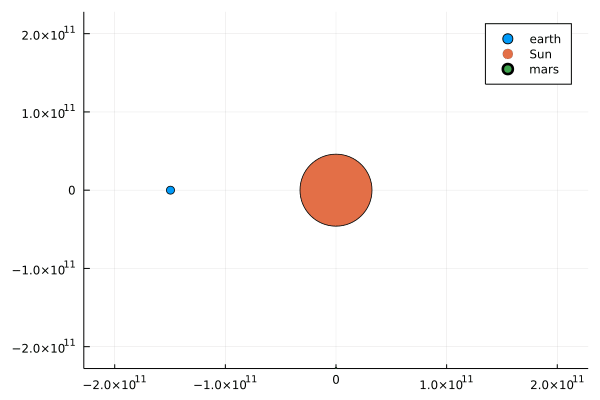

In [1]:
# Główny program do obliczania położenia ciał ( dla ukladu slonecznego )

using Plots, AstroLib


# Ważne stałe
G = 6.6732*10^(-11)     # stała grawitacji 
MS = 1.99e30    #masa slonca
RS = 695000000.0 #radius slonca

#lista planet które chcemy wyswietlić - mozna pozniej zautomatyzwac zaladowanie slowniknów
planet_names = ["earth", "mars"]

#dla listy planet bierzemy dane z AstroLib
function get_axis(planet_names)
    [AstroLib.planets[i].axis for i in planet_names]
end

function get_mass(planet_names)
   [AstroLib.planets[i].mass for i in planet_names]
end

function get_radius(planet_names)
    [AstroLib.planets[i].radius for i in planet_names]
end

masses = get_mass(planet_names)
axis = get_axis(planet_names)
radius = get_radius(planet_names)

#wyznaczamy granice wykresy dla najdalszej planety 
xlimit = axis[1]
for i in 2:length(axis)
    if xlimit < axis[i] 
        xlimit = axis[i]
    end     
end

xlimit += 1000
# Parametry początkowe obiektów - uwaga mam problem z wyznaczeniem vektoru momentu początkowego - troche na chybil traf,
#skalowanie planet sluży tylko do ich pokazania, tzn jowisz może wyjść większy od słońca wiec trzeba nad tym popracować
Planeta1 = Dict("M" => masses[1], 
    "position" => [-axis[1],0], 
      "moment_vec" => MS * [0,sqrt(G*masses[1]^2/(axis[1]*(MS+masses[1])))],"radiusscaled" => radius[1]/RS*600)


#uwaga - na razie słonće to zawsze planeta nr 2
Planeta2 = Dict("M" => MS, "position" => [0.0,0.0], "moment_vec" => [0.0,0.0],"radiusscaled" => 40.0)

Planeta3 = Dict("M" => masses[2], "position" => [0,-axis[2]],"moment_vec" => MS* [-sqrt(G*masses[2]^2/(axis[2]*(MS+masses[2]))),0]
,"radiusscaled" => radius[2]/RS*400)


#uwaga jak dolozymy planete trzeba uzupelnic slownik oraz dopisac do listy ponizej

lista=[Planeta1, Planeta2,Planeta3]
#---------------------------------------------------------------------------------------------
#       FUNKCJE DO OBLICZEŃ 
#---------------------------------------------------------------------------------------------

dist_vec(coord1,coord2) = coord2 .- coord1
"""Wylicza wektor odległości z coord1 do coord2"""

vec_length(v::Array) = sqrt(sum(v.^2))
"""Wylicza długość wektora"""

F_gravity(M1::Number,M2::Number,r::Array) = (G*M1*M2/vec_length(r)^3).*r
"""Wylicza wektor siły grawitacji"""

# nie uzywam tej funkcji 
function MainFunction(l,t::Number)
    for i in 1:length(lista)
        FG=[0.0,0.0]
        for j in 1:length(lista)
            if j!=i
                r=dist_vec(get(lista[i],"coord",1),get(lista[j],"coord",1))
                F=F_gravity(get(lista[i],"M",1),get(lista[j],"M",1),r)
                FG .+= F
            end
        end
        a_vec=FG./lista[i]["M"]
        lista[i]["v_vec"]=a_vec.*t.+lista[i]["v_vec"]
    end
    for i in 1:length(lista)
        lista[i]["coord"]=lista[i]["coord"].+lista[i]["v_vec"]
    end
        

 #   r = dist_vec(get(P1,"coord",1),get(P2,"coord",1))   # wektor odległości z P1 do P2
 #   F1 = F_gravity(get(P1,"M",1),get(P2,"M",1),r)       # oblicza wektory siły grawitacji
 #   F2 = (-1).*F1

 #   a_vec1 = F1/P1["M"]                          # oblicza wektory przyspieszania
 #   a_vec2 = F2/P2["M"]

 #   P1["v_vec"] = a_vec1.*t + P1["v_vec"]                  # nowy wektor prędkości planet
 #   P2["v_vec"] = a_vec2.*t + P2["v_vec"]

 #  P1["coord"] = P1["coord"] + P1["v_vec"]                   # nowe położenia planet
 #  P2["coord"] = P2["coord"] + P2["v_vec"]
end

#-------------------------------------------------------------------------------------------
#               RYSOWANIE WYKRESU
#-------------------------------------------------------------------------------------------

#t = 0:300000        # ilość elementów/klatek
T = 1000              # przedział czasowy 
n = 20             # ilość przeliczeń na każdą klatkę symulacji
fps = 10          # ilość kaltek na sekundę w symulacji

#czy to jest ilość klatek?
t = 1:1000
# Uwaga to jest delta t - im wieksza to obliczenia mniej dokladne ale nie moze byc za mala bo komp tego nie udzwignie
Deltat = 30000

symulation = @animate for k in t
    # rysuj pierwszą planetę
    scatter([lista[1]["position"][1]],[lista[1]["position"][2]],
    xlim = (-xlimit,xlimit),
    ylim = (-xlimit,xlimit),
    markersize = lista[1]["radiusscaled"],
    label = planet_names[1])
    #rysuj pozostałe planety/slonce 
    for j in 2:length(lista)
        name = planet_names[j-1]
        if j == 2
            name = "Sun"
        end    
        scatter!([lista[j]["position"][1]],[lista[j]["position"][2]],
        markersize = lista[j]["radiusscaled"],
        label = name)
    end    
    
      for i in 1 : length(lista)
        FG=[0.0,0.0]
            #oblicz siłe przeciągania dla planety i
           for j in 1:length(lista)
               if j!=i
                 r=dist_vec(get(lista[i],"position",1),get(lista[j],"position",1))
                 F=F_gravity(get(lista[i],"M",1),get(lista[j],"M",1),r)
                FG .+= F
                end
            end 
        #updtejtuj wektor momentu dla i=tej planety
        lista[i]["moment_vec"] = lista[i]["moment_vec"] .+ FG*Deltat
        #updejtuj wektor pozycji dla -tej planety
        lista[i]["position"] = lista[i]["position"] .+ lista[i]["moment_vec"]*Deltat/lista[i]["M"]
         
            
        end

end

gif(symulation,"animacja.gif",fps=fps)